How has the world average of harvest, yield and production changed over time with respect to:
Region/Continent
Type of Crop
Global Figures
    Build a heatmap of production across regions for visualisation purposes.
    To represent the fluctuations in overall demand. Look for sharp spikes or sudden  
changes and attempt to attribute it to a major world event or key factor that could imply causation.

Is there an overall correlation between climate change and the crop data in selected economies (that are above a certain climate risk index) in Asia (which contributes to ⅔ of the world agricultural GDP) and is there a trend to be observed? 

In selected economies in Asia, what is the correlation between agricultural yield and the GDP of the nation (is it possible to tell whether that country is largely dependent on it's agro output)?

What is the overall impact of crop production on the pricing of respective crops in Asia?

Is it possible to forecast future production and yields and if so, what direction is the trend heading in?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pycountry_convert as pc
from sklearn import preprocessing
from sklearn.cluster import KMeans

In [2]:
crops_clean = pd.read_csv('datasets_cleaned/crops_cleaned.csv')
all_countries=pd.read_csv('datasets_cleaned/all_countries.csv')
crop_groups=pd.read_csv('datasets_cleaned/crop_groups.csv')
prices_clean=pd.read_csv('datasets_cleaned/producer_prices_cleaned.csv')
caffeine_prices_clean=pd.read_csv('datasets_cleaned/caffeine_prices_clean.csv')
rainfall=pd.read_csv('datasets_cleaned/rainfall_clean.csv')
temperatures=pd.read_csv('datasets_cleaned/temperatures_clean.csv')
gdp_data =pd.read_csv('datasets_cleaned/gdp_data.csv')

## Question: *What are the most and least yielding crop of each type as of 2018?*

In [3]:
# all the crop 'types'
crop_groups['crop_type'].unique()

array(['Treenuts', 'Others', 'Fruit', 'Cereals', 'Oilcrops', 'Vegetables',
       'Roots and Tubers', 'Pulses', 'Sugar Crops', 'Fibre Crops'],
      dtype=object)

In [4]:
crop_data = crops_clean.copy()
crop_data

,Area,Item,Element,1961,1962,1963,1964,1965,1966,1967,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
0,Afghanistan,"Almonds, with shell",Area harvested,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,11029.0,11210.0,13469.0,13490.0,14114.0,13703.0,14676.0,19481.0,19793.0,20053.0
1,Afghanistan,"Almonds, with shell",Yield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,39154.0,49955.0,45000.0,45960.0,29910.0,19996.0,16521.0,16859.0,13788.0,17161.0
2,Afghanistan,"Almonds, with shell",Production,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,43183.0,56000.0,60611.0,62000.0,42215.0,27400.0,24246.0,32843.0,27291.0,34413.0
3,Afghanistan,"Anise, badian, fennel, coriander",Area harvested,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,17748.0,17000.0,19500.0,18500.0,18500.0,30000.0,25000.0,25638.0,27582.0,25785.0
4,Afghanistan,"Anise, badian, fennel, coriander",Yield,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6203.0,6000.0,6414.0,6757.0,6757.0,7167.0,7200.0,7037.0,6954.0,7036.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50246,Net Food Importing Developing Countries,"Treenuts, Total",Yield,6118.0,6318.0,6618.0,6492.0,6417.0,6187.0,5978.0,...,4728.0,5415.0,5429.0,5417.0,5198.0,5177.0,5234.0,5514.0,5251.0,5461.0
50247,Net Food Importing Developing Countries,"Treenuts, Total",Production,255724.0,295318.0,315667.0,349663.0,341957.0,336409.0,318793.0,...,1338811.0,1370375.0,1619567.0,1662130.0,1772637.0,1835843.0,2090427.0,1953370.0,2076194.0,2219089.0
50248,Net Food Importing Developing Countries,Vegetables Primary,Area harvested,1877800.0,1925219.0,1992435.0,2054949.0,2039738.0,2138112.0,2172385.0,...,6215085.0,6377100.0,6423774.0,6456448.0,6578776.0,6792359.0,6989468.0,7030316.0,7043245.0,7233314.0
50249,Net Food Importing Developing Countries,Vegetables Primary,Yield,66297.0,67612.0,68080.0,69544.0,71377.0,72030.0,71793.0,...,115100.0,113551.0,114497.0,116388.0,115156.0,117847.0,118811.0,117457.0,116865.0,117018.0


In [5]:
# return the crop type of a given crop
def getCropType(crop):
    return crop_groups.loc[crop_groups['crop']==crop, 'crop_type'].iloc[0]

### Most and least yield crop of each type

In [6]:
# melting for yield values
rawMeltedYield = crops_clean.copy()[crops_clean['Element'] == 'Yield'].melt(id_vars=['Item'], value_vars=crops_clean.columns[3:],
                              var_name='Year', value_name='Yield')
rawMeltedYield = rawMeltedYield.groupby(['Year','Item'])['Yield'].mean().reset_index()
rawMeltedYield['Year'] = rawMeltedYield['Year'].astype(str)
rawMeltedYield['Item'] = rawMeltedYield['Item'].astype(str)


In [7]:
cropMeltedYield = pd.DataFrame(rawMeltedYield.loc[rawMeltedYield['Item'].isin(crop_groups['crop'])])

cropMeltedYield['crop_type']= cropMeltedYield['Item'].apply(lambda x: getCropType(x))

cropMeltedYield

,Year,Item,Yield,crop_type
0,1961,Agave fibres nes,8626.000000,Fibre Crops
1,1961,"Almonds, with shell",5492.853333,Treenuts
2,1961,"Anise, badian, fennel, coriander",8103.611940,Others
3,1961,Apples,67179.638462,Fruit
4,1961,Apricots,40263.585859,Fruit
...,...,...,...,...
9971,2018,"Walnuts, with shell",28358.469880,Treenuts
9972,2018,Watermelons,237755.746753,Fruit
9973,2018,Wheat,30050.128049,Cereals
9974,2018,Yams,95444.287356,Roots and Tubers


In [8]:
# print results (visual??)
for crop_type in crop_groups['crop_type'].unique():
    v = cropMeltedYield[cropMeltedYield['crop_type']==crop_type]
    print(crop_type)
    print(v.groupby('Item')['Yield'].mean().nlargest(5))
    print(v.groupby('Item')['Yield'].mean().nsmallest(5).sort_values(ascending=False))
    print()

Treenuts
Item
Brazil nuts, with shell    145723.793103
Walnuts, with shell         71683.024096
Nuts nes                    18489.642414
Chestnut                    15659.371082
Almonds, with shell         11520.883448
Name: Yield, dtype: float64
Item
Chestnut                   15659.371082
Almonds, with shell        11520.883448
Cashew nuts, with shell     9526.599469
Pistachios                  8449.195122
Hazelnuts, with shell       7459.238871
Name: Yield, dtype: float64

Others
Item
Chicory roots    134669.226293
Peppermint        94886.820197
Maté              84944.958128
Ginger            66107.016379
Spices nes        56857.407441
Name: Yield, dtype: float64
Item
Kola nuts                     4547.490716
Cocoa, beans                  3778.375364
Nutmeg, mace and cardamoms    3560.007958
Cloves                        3129.150000
Vanilla                       1933.857889
Name: Yield, dtype: float64

Fruit
Item
Carobs         170863.837438
Pineapples     166147.069531
Papayas    

## Question: *What are the most and least produced crop of each type as of 2018?*

In [9]:
# melting crop data production values with crop type
cropMeltedProd = crops_clean.copy()[crops_clean['Element'] == 'Production'].melt(id_vars=['Item'], value_vars=crops_clean.columns[3:],
                              var_name='Year', value_name='Production')
cropMeltedProd = cropMeltedProd.groupby(['Year','Item'])['Production'].sum().reset_index()
cropMeltedProd['Year'] = cropMeltedProd['Year'].astype(str)
cropMeltedProd['Item'] = cropMeltedProd['Item'].astype(str)
cropMeltedProd

,Year,Item,Production
0,1961,Agave fibres nes,1.644000e+05
1,1961,"Almonds, with shell",3.656713e+06
2,1961,"Anise, badian, fennel, coriander",4.029860e+05
3,1961,Apples,7.724258e+07
4,1961,Apricots,6.002292e+06
...,...,...,...
10145,2018,"Walnuts, with shell",1.672895e+07
10146,2018,Watermelons,5.039817e+08
10147,2018,Wheat,3.430499e+09
10148,2018,Yams,3.398853e+08


In [33]:
# taking crop single crop items only
cropMeltedProd = pd.DataFrame(cropMeltedProd.loc[cropMeltedProd['Item'].isin(crop_groups['crop'])])

# adding and filling another column for type of crop
cropMeltedProd['crop_type']= cropMeltedProd['Item'].apply(lambda x: getCropType(x))

cropMeltedProd

,Year,Item,Production,crop_type
0,1961,Agave fibres nes,1.644000e+05,Fibre Crops
1,1961,"Almonds, with shell",3.656713e+06,Treenuts
2,1961,"Anise, badian, fennel, coriander",4.029860e+05,Others
3,1961,Apples,7.724258e+07,Fruit
4,1961,Apricots,6.002292e+06,Fruit
...,...,...,...,...
10145,2018,"Walnuts, with shell",1.672895e+07,Treenuts
10146,2018,Watermelons,5.039817e+08,Fruit
10147,2018,Wheat,3.430499e+09,Cereals
10148,2018,Yams,3.398853e+08,Roots and Tubers


In [11]:
# print results (visual??)
for crop_type in crop_groups['crop_type'].unique():
    v = cropMeltedProd[cropMeltedProd['crop_type']==crop_type]
    print(crop_type)
    print(v.groupby('Item')['Production'].sum().nlargest(5))
    print(v.groupby('Item')['Production'].sum().nsmallest(5).sort_values(ascending=False))
    print()

Treenuts
Item
Cashew nuts, with shell    507675553.0
Almonds, with shell        365783079.0
Walnuts, with shell        357171527.0
Chestnut                   262234968.0
Hazelnuts, with shell      143156866.0
Name: Production, dtype: float64
Item
Chestnut                   262234968.0
Hazelnuts, with shell      143156866.0
Nuts nes                   136802035.0
Pistachios                  84516557.0
Brazil nuts, with shell     17729932.0
Name: Production, dtype: float64

Others
Item
Rice, paddy (rice milled equivalent)    9.568089e+10
Coffee, green                           1.717021e+09
Tobacco, unmanufactured                 1.711139e+09
Rubber, natural                         1.574153e+09
Tea                                     8.244083e+08
Name: Production, dtype: float64
Item
Peppermint                    15904026.0
Nutmeg, mace and cardamoms    15260648.0
Pyrethrum, dried               5113952.0
Vanilla                        1355189.0
Gums, natural                  1335144.0
Name

#ANSWER HERE!

## Question: *Which countries have produced highest number of different crop items as of 2018?*

In [29]:
# melting crop data production values with area
cropMeltedProd2 = crops_clean.copy()[crops_clean['Element'] == 'Production'].melt(id_vars=['Area','Item'], value_vars=crops_clean.columns[3:],
                              var_name='Year', value_name='Production')
cropMeltedProd2 = cropMeltedProd2.groupby(['Area','Item'])['Production'].sum().reset_index()
cropMeltedProd2['Area'] = cropMeltedProd2['Area'].astype(str)
cropMeltedProd2['Item'] = cropMeltedProd2['Item'].astype(str)
cropMeltedProd2

,Area,Item,Production
0,Afghanistan,"Almonds, with shell",816387.0
1,Afghanistan,"Anise, badian, fennel, coriander",250153.0
2,Afghanistan,Apples,2260156.0
3,Afghanistan,Apricots,2870921.0
4,Afghanistan,Barley,17782532.0
...,...,...,...
17191,Zimbabwe,Vanilla,398.0
17192,Zimbabwe,Vegetables Primary,8855959.0
17193,Zimbabwe,"Vegetables, fresh nes",7470505.0
17194,Zimbabwe,"Vegetables, leguminous nes",17007.0


In [13]:
filt1 = np.logical_and(cropMeltedProd2['Area'].isin(all_countries['0']), cropMeltedProd2['Production'] > 0)
view1 = cropMeltedProd2.loc[filt1]
view1

,Area,Item,Production
0,Afghanistan,"Almonds, with shell",816387.0
1,Afghanistan,"Anise, badian, fennel, coriander",250153.0
2,Afghanistan,Apples,2260156.0
3,Afghanistan,Apricots,2870921.0
4,Afghanistan,Barley,17782532.0
...,...,...,...
17191,Zimbabwe,Vanilla,398.0
17192,Zimbabwe,Vegetables Primary,8855959.0
17193,Zimbabwe,"Vegetables, fresh nes",7470505.0
17194,Zimbabwe,"Vegetables, leguminous nes",17007.0


In [190]:
print('Countries with most variation in crop produce:')
print(view1.groupby(['Area'])['Item'].count().nlargest(20))

Countries with most variation in crop produce:
Area
China                         137
China, mainland               132
Mexico                        125
Spain                         118
Turkey                        111
Morocco                       110
Peru                          110
Italy                         106
United States of America      106
Greece                        104
France                        101
Iran (Islamic Republic of)    100
Australia                      98
Bulgaria                       98
Kenya                          98
India                          96
Portugal                       96
Hungary                        95
Japan                          95
Ukraine                        93
Name: Item, dtype: int64


In [188]:
view1[view1['Area'].str.contains('Macao')]

,Area,Item,Production
3273,"China, Macao SAR",Pepper (piper spp.),7944.0


## Question: *What kind of clusters can be seen from annual production vs GDP?*

In [39]:
country_gdp = gdp_data[gdp_data['Area'].isin(all_countries['0'])] # only countries

# melting gdp data by area (country)
country_gdp_melted = country_gdp.copy()[country_gdp['Element'] == 'Value US$'].melt(id_vars=['Area'], value_vars=country_gdp.columns[3:],
                              var_name='Year', value_name='Gross Domestic Product')
country_gdp_melted['Area'] = country_gdp_melted['Area'].astype(str)
country_gdp_melted['Year'] = country_gdp_melted['Year'].astype(str)
country_gdp_melted

,Area,Year,Gross Domestic Product
0,Afghanistan,1990,3.621600e+03
1,Albania,1990,2.145775e+03
2,Algeria,1990,6.175138e+04
3,Angola,1990,1.366185e+04
4,Antigua and Barbuda,1990,4.594704e+02
...,...,...,...
5969,Viet Nam,2018,2.449011e+05
5970,Yemen,2018,2.667158e+04
5971,Yugoslav SFR,2018,1.563048e+06
5972,Zambia,2018,2.728285e+04


In [156]:
# filt1 = country_gdp_melted['Area']=='Australia'
filt2 = country_gdp_melted['Year']=='2018'
country_gdp_melted.loc[filt2].sort_values(by=['Gross Domestic Product'], ascending=False)

,Area,Year,Gross Domestic Product
5963,United States of America,2018,2.058022e+07
5805,China,2018,1.402538e+07
5808,"China, mainland",2018,1.360815e+07
5862,Japan,2018,4.971323e+06
5842,Germany,2018,3.949549e+06
...,...,...,...
5884,Marshall Islands,2018,2.141945e+02
5866,Kiribati,2018,1.885249e+02
5896,Nauru,2018,1.267154e+02
5891,Montserrat,2018,6.367881e+01


In [43]:
# melting crop data production values with area
cropMeltedProd3 = crops_clean.copy()[crops_clean['Element'] == 'Production'].melt(id_vars=['Area'], value_vars=crops_clean.columns[3:],
                              var_name='Year', value_name='Production')
cropMeltedProd3 = cropMeltedProd3.groupby(['Area','Year'])['Production'].sum().reset_index() # taking the total crop production that year
cropMeltedProd3['Area'] = cropMeltedProd3['Area'].astype(str)
cropMeltedProd3['Year'] = cropMeltedProd3['Year'].astype(str)
cropMeltedProd3


,Area,Year,Production
0,Afghanistan,1961,10113549.0
1,Afghanistan,1962,10234847.0
2,Afghanistan,1963,9742992.0
3,Afghanistan,1964,10592022.0
4,Afghanistan,1965,10901830.0
...,...,...,...
15017,Zimbabwe,2014,12737274.0
15018,Zimbabwe,2015,10730859.0
15019,Zimbabwe,2016,10727164.0
15020,Zimbabwe,2017,11341828.0


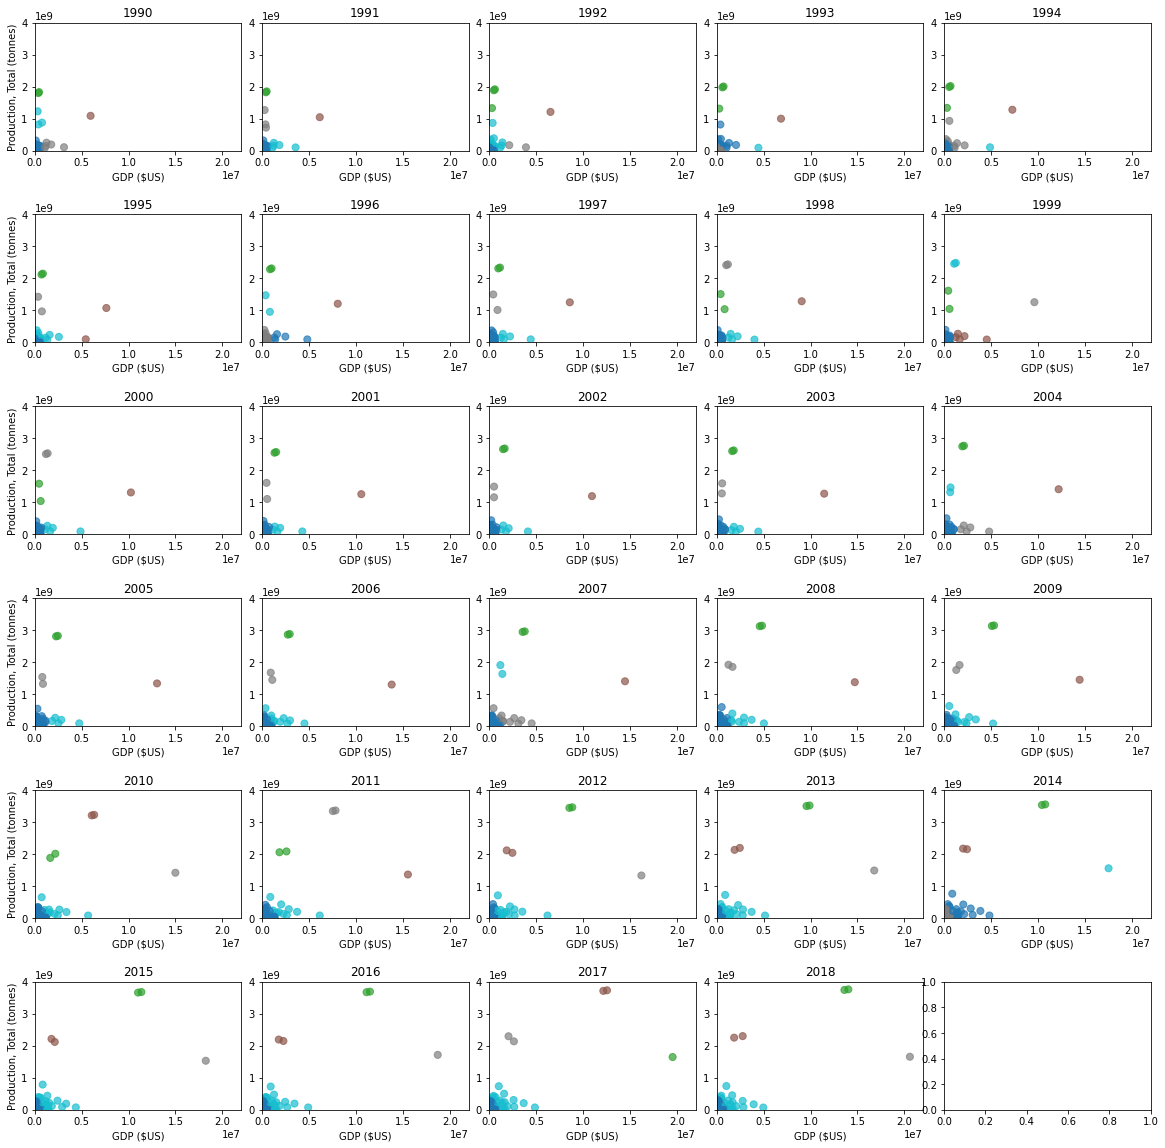

In [181]:
# setting up plot attributes
fig, axes = plt.subplots(6,5, figsize=(20, 20), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.1)

grid_combos = []
for i in range(6):
    for j in range(5):
        grid_combos.append((i, j))

# taking years from 1990 to 2018
years = [str(year) for year in range(1990, 2019)]

# KMeans clustering for each year, 
for i, year in enumerate(years):
    # taking country production and GDP for this year
    cropProd = cropMeltedProd3[cropMeltedProd3['Year'] == year]
    countryGDP = country_gdp_melted[country_gdp_melted['Year'] == year]
    prod_and_gdp = pd.merge(cropProd, countryGDP, on=['Year', 'Area'], how='inner') # merging production and gdp into a single table
    
    # scaling the numerical values
    scaler = preprocessing.MinMaxScaler() # min-max normalizer
    X = prod_and_gdp[['Production', 'Gross Domestic Product']] # numeric values only
    prod_and_gdp_scaled = pd.DataFrame(scaler.fit_transform(X)) # scaling numerics
    prod_and_gdp_scaled.rename(columns={0:'Production', 1:'Gross Domestic Product'}, inplace=True)

    # kmeans clustering
    model = KMeans(5, verbose=0) # fitting for 5 clusters
    model.fit(prod_and_gdp_scaled)

    kmeans_labels = pd.DataFrame(model.labels_)
    prod_and_gdp_scaled.loc[:, 'kmeans'] = kmeans_labels
    v1 = prod_and_gdp['Gross Domestic Product']
    v2 = prod_and_gdp['Production']
    
    row, col = grid_combos[i]
    axes[row, col].scatter(v1, v2, c=kmeans_labels[0], s=50,cmap='tab10',alpha=0.7)
    axes[row, col].set_title(year)
    axes[row, col].set(xlim=(0, 2.2e7))
    axes[row, col].set(ylim=(0, 4.0e9))
    axes[row, col].set_xlabel('GDP ($US)')
    
    if (col % 5 == 0):
        axes[row, col].set_ylabel('Production, Total (tonnes)')
    else:
        axes[row, col].set_ylabel('')
    

In [180]:
# studying the countries of the different groups in 2018
for g in range(0,5):  
    print(f'Group {g}:\n')
    print(prod_and_gdp.loc[(prod_and_gdp_scaled['kmeans'] == g), 'Area'])
    print()

Group 0:

23    Brazil
86     India
Name: Area, dtype: object

Group 1:

0                             Afghanistan
1                                 Albania
2                                 Algeria
3                                  Angola
4                     Antigua and Barbuda
                      ...                
200    Venezuela (Bolivarian Republic of)
201                              Viet Nam
202                                 Yemen
204                                Zambia
205                              Zimbabwe
Name: Area, Length: 180, dtype: object

Group 2:

37              China
40    China, mainland
Name: Area, dtype: object

Group 3:

5                                              Argentina
7                                              Australia
32                                                Canada
50                                        Czechoslovakia
66                                          Ethiopia PDR
69                                               